In [1]:
import datetime as datetime
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import unidecode
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stopwords = nltk.corpus.stopwords.words('english')


import sklearn as sk
import xgboost 
from xgboost import XGBClassifier

from matplotlib import pyplot
from sklearn.utils import shuffle
from numpy import sort
from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import accuracy_score, r2_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier

[nltk_data] Downloading package stopwords to /home/martin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('../../train.csv', low_memory=False)
test = pd.read_csv('../../test.csv', low_memory=False)

In [3]:
def concatenate(x,char):
    words = ""
    for word in x:
        if word.startswith(char):
            words = words + word + " "
    return words

def count_vowels(x):
    return (x.count('a') + x.count('e') + x.count('i') + x.count('o') + x.count('u'))

def count_short_words(x):
    count = 0
    words = x.split(' ')
    for word in words:
        if 1 <= len(word) <= 3:
            count += 1
    return count

def count_stopwords(x):
    count = 0
    words = x.split(' ')
    for word in words:
        if word in stopwords:
            count += 1
    return count

In [4]:
def remove_punctuation(word):        
    clean_word = ''.join([char for char in word if char not in string.punctuation])
    return clean_word

def cleaning_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    text_tokenize = tokenizer.tokenize(text)
    wordlist = []
    for word in text_tokenize:
        word = word.lower()
        word = re.sub('(?P<url>https?://[^\s]+)', ' ', word)
        word = remove_punctuation(word)
        word = re.sub(r'[^\w]', ' ', word)
        word = unidecode.unidecode(word)
        word = re.sub(r'[0-9]','', word)
        if((word != '')&(word != ' ')&(word not in stopwords)):
            wordlist.append(word)
    clean_text = ' '.join(wordlist)
    return clean_text

In [5]:
train["special_chars_count"] =  train["text"]
train["special_chars_count"] =  train["special_chars_count"].str.lower()
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
train["special_chars_count"] = train["special_chars_count"].str.strip()
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(' +','', x))
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(r'[0-9]','', x))
train["special_chars_count"] = train["special_chars_count"].str.len()

train["hashtags"] = train["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'#'))
train["labels"] = train["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'@'))
train["hashtags_count"] = train["hashtags"].str.split(' ').apply(lambda x: len(x))-1
train["labels_count"] = train["labels"].str.split(' ').apply(lambda x: len(x))-1

train["num_chars_count"] = train["text"]
train["num_chars_count"] =  train["num_chars_count"].str.lower()
train["num_chars_count"] = train["num_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
train["num_chars_count"] = train["num_chars_count"].apply(lambda x: re.sub(r'[^\w]','',x))
train["num_chars_count"] = train["num_chars_count"].str.strip()
train["num_chars_count"] = train["num_chars_count"].str.len()

train["clean_text"] = train["text"].apply(lambda x: cleaning_text(x))

train["text"] = train["text"].str.lower()
train["text"] = train["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'_', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(' +',' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
train["text"] = train["text"].apply(lambda x: unidecode.unidecode(x))
train["text"] = train["text"].str.strip()
train["text_length"] = train["text"].str.len()
train["words_count"] = train["text"].str.split(' ').apply(lambda x: len(x))

train["keyword"] = train["keyword"].str.replace('%20',' ')

train["vowels_count"] = train["text"].apply(lambda x: count_vowels(x))
train["short_words_count"] = train["text"].apply(lambda x: count_short_words(x))
train["stopwords_count"] = train["text"].apply(lambda x: count_stopwords(x))


train.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,1,#earthquake,,1,0,0,deeds reason earthquake may allah forgive us,68,13,25,7,6
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,,,0,0,0,forest fire near la ronge sask canada,37,7,13,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,3,,,0,0,0,residents asked shelter place notified officer...,130,22,45,9,11
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1,2,#wildfires,,1,0,5,people receive wildfires evacuation orders cal...,56,7,24,1,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,2,#alaska #wildfires,,2,0,0,got sent photo ruby alaska smoke wildfires pou...,84,16,24,2,6


In [6]:
test["special_chars_count"] =  test["text"]
test["special_chars_count"] =  test["special_chars_count"].str.lower()
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
test["special_chars_count"] = test["special_chars_count"].str.strip()
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(' +','', x))
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(r'[0-9]','', x))
test["special_chars_count"] = test["special_chars_count"].str.len()

test["hashtags"] = test["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'#'))
test["labels"] = test["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'@'))
test["hashtags_count"] = test["hashtags"].str.split(' ').apply(lambda x: len(x))-1
test["labels_count"] = test["labels"].str.split(' ').apply(lambda x: len(x))-1

test["num_chars_count"] = test["text"]
test["num_chars_count"] =  test["num_chars_count"].str.lower()
test["num_chars_count"] = test["num_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
test["num_chars_count"] = test["num_chars_count"].apply(lambda x: re.sub(r'[^\w]','',x))
test["num_chars_count"] = test["num_chars_count"].str.strip()
test["num_chars_count"] = test["num_chars_count"].str.len()

test["clean_text"] = test["text"].apply(lambda x: cleaning_text(x))

test["text"] = test["text"].str.lower()
test["text"] = test["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'_', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(' +',' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
test["text"] = test["text"].apply(lambda x: unidecode.unidecode(x))
test["text"] = test["text"].str.strip()
test["text_length"] = test["text"].str.len()
test["words_count"] = test["text"].str.split(' ').apply(lambda x: len(x))

test["keyword"] = test["keyword"].str.replace('%20',' ')

test["vowels_count"] = test["text"].apply(lambda x: count_vowels(x))
test["short_words_count"] = test["text"].apply(lambda x: count_short_words(x))
test["stopwords_count"] = test["text"].apply(lambda x: count_stopwords(x))


test.head()

,id,keyword,location,text,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,0,NaN,NaN,just happened terrible car crash,0,,,0,0,0,happened terrible car crash,33,6,9,1,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,3,#earthquake,,1,0,0,heard earthquake different cities stay safe ev...,61,9,24,1,2
2,3,NaN,NaN,there is forest fire at spot pond geese are f...,2,,,0,0,0,forest fire spot pond geese fleeing across str...,92,19,29,5,7
3,9,NaN,NaN,apocalypse lighting spokane wildfires,3,#spokane #wildfires,,2,0,0,apocalypse lighting spokane wildfires,37,4,12,0,0
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,0,,,0,0,2,typhoon soudelor kills china taiwan,42,7,14,2,2


In [7]:
tweets = pd.concat([train, test], sort=False)
tweets

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,deeds reason earthquake may allah forgive us,68,13,25,7,6
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,forest fire near la ronge sask canada,37,7,13,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,residents asked shelter place notified officer...,130,22,45,9,11
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,people receive wildfires evacuation orders cal...,56,7,24,1,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,got sent photo ruby alaska smoke wildfires pou...,84,16,24,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles uo safety fasten...,NaN,3,,,0,0,2,earthquake safety los angeles uo safety fasten...,54,8,18,2,0
3259,10865,NaN,NaN,storm in ri worse than last hurricane my city ...,NaN,5,,,0,0,6,storm ri worse last hurricane city others hard...,129,25,36,8,6
3260,10868,NaN,NaN,green line derailment in chicago,NaN,5,,,0,0,0,green line derailment chicago,32,5,12,1,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN,7,,,0,0,3,meg issues hazardous weather outlook hwo,40,6,16,2,0


## One Hot Encoding

In [8]:
OHE = pd.get_dummies(tweets, prefix=['keyword'], columns=['keyword'])

In [9]:
# Vectorize the text
vectorizer = CountVectorizer(stop_words='english', min_df=20)
df_text = tweets["text"]
text_vector = vectorizer.fit_transform(df_text)

In [10]:
vectorizer.get_feature_names()

['aba',
 'abc',
 'ablaze',
 'absolutely',
 'accident',
 'action',
 'actually',
 'added',
 'affected',
 'aftershock',
 'ago',
 'ahead',
 'ain',
 'air',
 'aircraft',
 'airplane',
 'airport',
 'alarm',
 'album',
 'ambulance',
 'america',
 'american',
 'amid',
 'amp',
 'ancient',
 'angry',
 'annihilated',
 'annihilation',
 'anniversary',
 'anthrax',
 'apocalypse',
 'apollo',
 'appears',
 'area',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'art',
 'ashes',
 'ass',
 'atomic',
 'attack',
 'attacked',
 'aug',
 'august',
 'australia',
 'avalanche',
 'ave',
 'away',
 'awesome',
 'baby',
 'bad',
 'bag',
 'bagging',
 'bags',
 'ball',
 'bang',
 'banned',
 'bar',
 'battle',
 'bbc',
 'bc',
 'beach',
 'beat',
 'beautiful',
 'believe',
 'best',
 'better',
 'big',
 'bigger',
 'biggest',
 'bioterror',
 'bioterrorism',
 'bit',
 'black',
 'blast',
 'blaze',
 'blazing',
 'bleeding',
 'blew',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown',
 'blue',
 'boat',
 'bodies',
 'body',
 'bomb',
 'bombed',


In [11]:
df_bow = pd.DataFrame(text_vector.toarray(), columns=vectorizer.get_feature_names())
df_bow.head()

,aba,abc,ablaze,absolutely,accident,action,actually,added,affected,aftershock,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
OHE_BOW = pd.concat([OHE, df_bow.reindex(OHE.index)], axis=1)
OHE_BOW.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
OHE_BOW_TRAIN = OHE_BOW.loc[OHE_BOW['target'].notnull(),:]
OHE_BOW_TRAIN.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
OHE_BOW_TEST = OHE_BOW.loc[OHE_BOW['target'].isnull(),:]
OHE_BOW_TEST.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,NaN,just happened terrible car crash,NaN,0,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,NaN,heard about earthquake is different cities sta...,NaN,3,#earthquake,,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,there is forest fire at spot pond geese are f...,NaN,2,,,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,NaN,apocalypse lighting spokane wildfires,NaN,3,#spokane #wildfires,,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,NaN,typhoon soudelor kills in china and taiwan,NaN,0,,,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data2 = OHE_BOW_TRAIN.drop(["id","location","text","target", "hashtags", "clean_text", "labels"], axis=1)
target2 = OHE_BOW_TRAIN["target"]

In [16]:
data2.columns

Index(['special_chars_count', 'hashtags_count', 'labels_count',
       'num_chars_count', 'text_length', 'words_count', 'vowels_count',
       'short_words_count', 'stopwords_count', 'keyword_ablaze',
       ...
       'year', 'years', 'yes', 'yesterday', 'york', 'young', 'youth',
       'youtube', 'yr', 'zone'],
      dtype='object', length=1180)

In [17]:
kaggleId = OHE_BOW_TEST.id

In [18]:
data_test = OHE_BOW_TEST.drop(["id","location","text", "target","hashtags", "clean_text", "labels"], axis=1)

In [19]:
data_test.columns

Index(['special_chars_count', 'hashtags_count', 'labels_count',
       'num_chars_count', 'text_length', 'words_count', 'vowels_count',
       'short_words_count', 'stopwords_count', 'keyword_ablaze',
       ...
       'year', 'years', 'yes', 'yesterday', 'york', 'young', 'youth',
       'youtube', 'yr', 'zone'],
      dtype='object', length=1180)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data2, target2, test_size = 0.25)

In [21]:
# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', min_df=20)
df_text = tweets["text"]
text_vector = vectorizer.fit_transform(df_text)

In [22]:
feature_words = vectorizer.get_feature_names()
df_tfidf = pd.DataFrame(text_vector.toarray(), columns=feature_words)
df_tfidf.head()

,aba,abc,ablaze,absolutely,accident,action,actually,added,affected,aftershock,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
OHE_TFIDF = pd.concat([OHE, df_tfidf.reindex(OHE.index)], axis=1)
OHE_TFIDF.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
OHE_TFIDF_TRAIN = OHE_TFIDF.loc[OHE_TFIDF['target'].notnull(),:]
OHE_TFIDF_TRAIN.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
OHE_TFIDF_TEST = OHE_TFIDF.loc[OHE_TFIDF['target'].isnull(),:]
OHE_TFIDF_TEST.head()

,id,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,NaN,just happened terrible car crash,NaN,0,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,heard about earthquake is different cities sta...,NaN,3,#earthquake,,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,there is forest fire at spot pond geese are f...,NaN,2,,,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,NaN,apocalypse lighting spokane wildfires,NaN,3,#spokane #wildfires,,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,NaN,typhoon soudelor kills in china and taiwan,NaN,0,,,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data3 = OHE_TFIDF_TRAIN.drop(["id","location","text","target", "hashtags", "clean_text", "labels"], axis=1)
target3 = OHE_TFIDF_TRAIN["target"]

In [27]:
data_test2 = OHE_TFIDF_TEST.drop(["id","location","text", "target","hashtags", "clean_text", "labels"], axis=1)

In [28]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data3, target3, test_size = 0.25)

In [103]:
# feature selection
def select_features(x_train, y_train, x_test):
    fs = SelectKBest(score_func=chi2, k=50)
    fs.fit(x_train, y_train)
    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)
    return x_train_fs, x_test_fs, fs

In [104]:
x_train_fs, x_test_fs, fs = select_features(x_train2, y_train2, x_test2)

In [92]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 766.212201
Feature 1: 2.387398
Feature 2: 0.701951
Feature 3: 9.480782
Feature 4: 19.559853
Feature 5: 22.166213
Feature 6: 0.611665
Feature 7: 0.087732
Feature 8: 0.200536
Feature 9: 1.330377
Feature 10: 11.409556
Feature 11: 8.712438
Feature 12: 6.207946
Feature 13: 4.183613
Feature 14: 8.621636
Feature 15: 2.307870
Feature 16: 9.763098
Feature 17: 3.665755
Feature 18: 2.309776
Feature 19: 10.687561
Feature 20: 12.451391
Feature 21: 11.745514
Feature 22: 6.123873
Feature 23: 11.726300
Feature 24: 11.003574
Feature 25: 10.727474
Feature 26: 8.712438
Feature 27: 11.726300
Feature 28: 4.783849
Feature 29: 13.231566
Feature 30: 13.178576
Feature 31: 22.569061
Feature 32: 0.489332
Feature 33: 0.299815
Feature 34: 20.668662
Feature 35: 24.567370
Feature 36: 10.073373
Feature 37: 18.438287
Feature 38: 3.657366
Feature 39: 1.856196
Feature 40: 0.914938
Feature 41: 4.138631
Feature 42: 12.835222
Feature 43: 0.299815
Feature 44: 5.855893
Feature 45: 3.750770
Feature 46: 0.062869
Fea

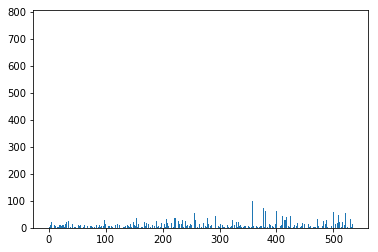

In [93]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [105]:
# feature selection
def select_features2(x_train, y_train, x_test):
    fs2 = SelectKBest(score_func=mutual_info_classif, k=50)
    fs2.fit(x_train, y_train)
    x_train_fs2 = fs2.transform(x_train)
    x_test_fs2 = fs2.transform(x_test)
    return x_train_fs2, x_test_fs2, fs2

In [106]:
x_train_fs2, x_test_fs2, fs2 = select_features2(x_train2, y_train2, x_test2)

In [96]:
# what are scores for the features
for i in range(len(fs2.scores_)):
    print('Feature %d: %f' % (i, fs2.scores_[i]))

Feature 0: 0.013797
Feature 1: 0.004487
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.004174
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.006084
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.000000
Feature 12: 0.007043
Feature 13: 0.000000
Feature 14: 0.000000
Feature 15: 0.000000
Feature 16: 0.000000
Feature 17: 0.000000
Feature 18: 0.000631
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.000892
Feature 22: 0.000288
Feature 23: 0.006830
Feature 24: 0.002312
Feature 25: 0.000000
Feature 26: 0.001890
Feature 27: 0.004345
Feature 28: 0.000000
Feature 29: 0.003103
Feature 30: 0.006793
Feature 31: 0.000000
Feature 32: 0.000000
Feature 33: 0.000000
Feature 34: 0.002847
Feature 35: 0.000000
Feature 36: 0.000000
Feature 37: 0.005141
Feature 38: 0.000000
Feature 39: 0.000000
Feature 40: 0.000000
Feature 41: 0.006116
Feature 42: 0.010695
Feature 43: 0.000000
Feature 44: 0.002634
Feature 45: 0.000000
Feature 46: 0.000000
Feature 47: 0.000000
Fe

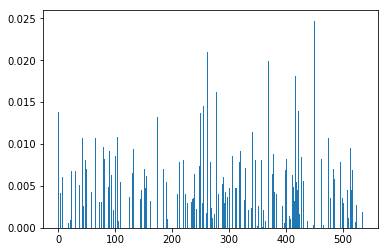

In [97]:
# plot the scores
pyplot.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
pyplot.show()

In [107]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train2, y_train2)
# evaluate the model
yhat = model.predict(x_test2)
# evaluate predictions
accuracy = accuracy_score(y_test2, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 77.21


/home/martin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [108]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train_fs, y_train2)
# evaluate the model
yhat = model.predict(x_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test2, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 71.48


/home/martin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [109]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train_fs2, y_train2)
# evaluate the model
yhat = model.predict(x_test_fs2)
# evaluate predictions
accuracy = accuracy_score(y_test2, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 64.65


/home/martin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Logistic Regression

## Con BOW

In [29]:
log_reg_grid_param = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.7317841640436289


#log_reg_grid_param = {'solver': ['liblinear', 'lbfgs', 'newton-cg'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 206.913808111479, 'solver': 'liblinear'}
# accuracy : 0.6762867722923174

#log_reg_grid_param = {'penalty': ['l1', 'l2'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 11.288378916846883, 'penalty': 'l1'}
# accuracy : 0.6773280120566767

In [30]:
logisticReggesion = LogisticRegression()

In [31]:
logistic_GS = GridSearchCV(estimator=logisticReggesion, param_grid=log_reg_grid_param, verbose=1, scoring="f1", cv=5, n_jobs=-1)
logistic_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",logistic_GS.best_params_)
print("accuracy :",logistic_GS.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.0s


tuned hpyerparameters :(best parameters)  {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.7331606524706379


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.1s finished


In [42]:
logistic_GS_predict = logistic_GS.predict(data_test)

In [43]:
logistic_GS_predict = logistic_GS_predict.astype('int64')
logistic_GS_predict

array([1, 1, 0, ..., 0, 1, 0])

In [44]:
kaggle_logistic_GS_submit = {'id': kaggleId, 'target': logistic_GS_predict}
kaggle_logistic_GS_submit_DF = pd.DataFrame(data=kaggle_logistic_GS_submit)

In [45]:
kaggle_logistic_GS_submit_DF.to_csv('setSubmitLogistic.csv', index=False)

## Con TF-IDF

In [32]:
log_reg_grid_param2 = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.7317841640436289


#log_reg_grid_param = {'solver': ['liblinear', 'lbfgs', 'newton-cg'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 206.913808111479, 'solver': 'liblinear'}
# accuracy : 0.6762867722923174

#log_reg_grid_param = {'penalty': ['l1', 'l2'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 11.288378916846883, 'penalty': 'l1'}
# accuracy : 0.6773280120566767

In [33]:
logisticReggesion2 = LogisticRegression()

In [34]:
logistic_GS2 = GridSearchCV(estimator=logisticReggesion2, param_grid=log_reg_grid_param2, verbose=1, scoring="f1", cv=5, n_jobs=-1)
logistic_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",logistic_GS2.best_params_)
print("accuracy :",logistic_GS2.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.1s


tuned hpyerparameters :(best parameters)  {'C': 1.623776739188721, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.73602370035538


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.6s finished


In [35]:
logistic_GS2_predict = logistic_GS2.predict(data_test)

In [39]:
logistic_GS2_predict = logistic_GS2_predict.astype('int32')
logistic_GS2_predict

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [40]:
kaggle_logistic_GS2_submit = {'id': kaggleId, 'target': logistic_GS2_predict}
kaggle_logistic_GS2_submit_DF = pd.DataFrame(data=kaggle_logistic_GS2_submit)

In [41]:
kaggle_logistic_GS2_submit_DF.to_csv('setSubmitLogistic.csv', index=False)

# KNN

## Con BOW

In [86]:
#knn_grid_param = {'n_neighbors': [3,5,11,19],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
# accuracy : 0.5584487464918637

#knn_grid_param = {'n_neighbors': [11,19,25,30],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
# accuracy : 0.5584487464918637

#knn_grid_param = {'n_neighbors': [14,15,16,17,18,19,20],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

knn_grid_param = {'n_neighbors': [17,50,100,150,200],
               'algorithm': ['auto'],
               'metric': ['manhattan', 'euclidean'],
                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

In [47]:
knnClassifier = KNeighborsClassifier()

In [87]:
knn_GS = GridSearchCV(estimator=knnClassifier, param_grid=knn_grid_param, verbose=1, scoring="f1", cv=5, n_jobs=-1)
knn_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",knn_GS.best_params_)
print("accuracy :",knn_GS.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
accuracy : 0.5602674085086873


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.1s finished


## Con TF-IDF

In [225]:
#knn_grid_param2 = {'n_neighbors': [3,5,10,15],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
# accuracy : 0.5189932870856757

knn_grid_param2 = {'n_neighbors': [2,3,4],
               'algorithm': ['auto'],
               'metric': ['manhattan', 'euclidean'],
                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
# accuracy : 0.5189932870856757

#knn_grid_param = {'n_neighbors': [14,15,16,17,18,19,20],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

#knn_grid_param = {'n_neighbors': [17,50,100,150,200],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

In [226]:
knnClassifier2 = KNeighborsClassifier()

In [227]:
knn_GS2 = GridSearchCV(estimator=knnClassifier2, param_grid=knn_grid_param2, verbose=1, scoring="f1", cv=5, n_jobs=-1)
knn_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",knn_GS2.best_params_)
print("accuracy :",knn_GS2.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
accuracy : 0.5118324014678401


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.3s finished


In [228]:
knn_GS2_predict = knn_GS2.predict(data_test)

In [229]:
kaggle_knn_GS2_submit = {'id': kaggleId, 'target': knn_GS2_predict}
kaggle_knn_GS2_submit_DF = pd.DataFrame(data=kaggle_knn_GS2_submit)

In [230]:
kaggle_knn_GS2_submit_DF.to_csv('setSubmitKNN.csv', index=False)

# Decision Tree

## Con BOW

In [94]:
decision_tree_grid = {'max_depth': [20,40,60,80,100],
                     'min_samples_split': [2,4,6,8,10],
                     'min_samples_leaf': [1,2,5,10]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 2}
# accuracy : 0.5733099080349381

In [89]:
decisionClassifier = DecisionTreeClassifier()

In [95]:
decision_GS = GridSearchCV(estimator=decisionClassifier, param_grid=decision_tree_grid, scoring='f1', verbose=1, cv=5, n_jobs=-1)
decision_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",decision_GS.best_params_)
print("accuracy :",decision_GS.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.0s


tuned hpyerparameters :(best parameters)  {'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy : 0.5733099080349381


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.4s finished


## Con TF-IDF

In [231]:
#decision_tree_grid2 = {'max_depth': [20,40,60,80,100],
#                     'min_samples_split': [2,4,6,8,10],
#                     'min_samples_leaf': [1,2,5,10]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 10}
# accuracy : 0.6500121884229279

#decision_tree_grid2 = {'max_depth': [90,100,150,200],
#                     'min_samples_split': [8,10,12,15],
#                     'min_samples_leaf': [1,2,3]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 150, 'min_samples_leaf': 1, 'min_samples_split': 10}
# accuracy : 0.6560101863933094

decision_tree_grid2 = {'max_depth': [140,150,160],
                     'min_samples_split': [8,9,10,11],
                     'min_samples_leaf': [1,2,3]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 8}
# accuracy : 0.6566691438892028

In [232]:
decisionClassifier2 = DecisionTreeClassifier()

In [233]:
decision_GS2 = GridSearchCV(estimator=decisionClassifier2, param_grid=decision_tree_grid2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
decision_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",decision_GS2.best_params_)
print("accuracy :",decision_GS2.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.4s finished


tuned hpyerparameters :(best parameters)  {'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 11}
accuracy : 0.6548244837284463


In [234]:
decision_GS2_predict = decision_GS2.predict(data_test)

In [235]:
kaggle_decision_GS2_submit = {'id': kaggleId, 'target': decision_GS2_predict}
kaggle_decision_GS2_submit_DF = pd.DataFrame(data=kaggle_decision_GS2_submit)

In [236]:
kaggle_decision_GS2_submit_DF.to_csv('setSubmitDecision.csv', index=False)

# Random Forest

## Con BOW

In [18]:
#random_forest_grid_param = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#random_forest_grid_param = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
#accuracy : 0.653347094748209

#random_forest_grid_param = {'bootstrap': [True],
#                            'max_depth': [2, 4, 6, None],
#                            'max_features': ['sqrt'],
#                            'min_samples_leaf': [1, 5, 7],
#                            'min_samples_split': [9, 10, 11],
#                            'n_estimators': [50,100,200]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
#accuracy : 0.6534201199529246

random_forest_grid_param = {'bootstrap': [True],
                            'max_depth': [2, 4, 6, None],
                            'max_features': ['sqrt'],
                            'min_samples_leaf': [1,10,15],
                            'min_samples_split': [9, 10, 11],
                            'n_estimators': [20,30,50,75]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 20}
#accuracy : 0.6541641584525214

#random_forest_grid_param = {'bootstrap': [True],
#                            'max_depth': [50, 60, 70, None],
#                            'max_features': ['sqrt'],
#                            'min_samples_leaf': [1,2,3],
#                            'min_samples_split': [9, 10, 11],
#                            'n_estimators': [5,9,12,15,20]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 15}
#accuracy : 0.6492213934204937

In [14]:
rfClassifier = RandomForestClassifier()

In [19]:
rf_GS = GridSearchCV(estimator=rfClassifier, param_grid=random_forest_grid_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
rf_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",rf_GS.best_params_)
print("accuracy :",rf_GS.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   33.4s finished


tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 15}
accuracy : 0.6492213934204937


## Con TF-IDF

In [52]:
#random_forest_grid_param2 = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#random_forest_grid_param2 = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 
# 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
#accuracy : 0.7212366222022716

random_forest_grid_param2 = {'bootstrap': [True],
                            'max_depth': [None],
                            'max_features': ['sqrt'],
                            'min_samples_leaf': [1,2,10],
                            'min_samples_split': [12,15,17,20],
                            'n_estimators': [35,50,75]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 
#'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#accuracy : 0.7152005800228897

In [50]:
rfClassifier2 = RandomForestClassifier()

In [53]:
rf_GS2 = GridSearchCV(estimator=rfClassifier2, param_grid=random_forest_grid_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
rf_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",rf_GS2.best_params_)
print("accuracy :",rf_GS2.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 75}
accuracy : 0.7150790281708316


In [ ]:
rf_GS2_predict = rf_GS2.predict(data_test)

In [ ]:
kaggle_rf_GS2_submit = {'id': kaggleId, 'target': rf_GS2_predict}
kaggle_rf_GS2_submit_DF = pd.DataFrame(data=kaggle_rf_GS2_submit)

In [ ]:
kaggle_rf_GS2_submit_DF.to_csv('setSubmitRF.csv', index=False)

# Ada Boost

## Con BOW

In [31]:
ada_grid = {'n_estimators': np.arange(280,400,10),
            'learning_rate' : [0.01,0.05,0.1,0.3,0.7,1]}
#tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 350}
#accuracy : 0.6775816558491128

In [24]:
ada = AdaBoostClassifier()

In [32]:
ada_GS = GridSearchCV(estimator=ada, param_grid=ada_grid, scoring='f1', verbose=1, cv=5, n_jobs=-1)
ada_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",ada_GS.best_params_)
print("accuracy :",ada_GS.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.6min finished


tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 350}
accuracy : 0.6775816558491128


## Con TF-IDF

In [55]:
ada_grid2 = {'n_estimators': np.arange(280,500,10),
            'learning_rate' : [0.01,0.1,0.5,1]}
#tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 490}
#accuracy : 0.7135560234410868

In [56]:
ada2 = AdaBoostClassifier()

In [57]:
ada_GS2 = GridSearchCV(estimator=ada2, param_grid=ada_grid2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
ada_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",ada_GS2.best_params_)
print("accuracy :",ada_GS2.best_score_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed: 25.3min finished


tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 490}
accuracy : 0.7135560234410868


In [58]:
ada_GS2_predict = ada_GS2.predict(data_test)

In [59]:
kaggle_ada_GS2_submit = {'id': kaggleId, 'target': ada_GS2_predict}
kaggle_ada_GS2_submit_DF = pd.DataFrame(data=kaggle_ada_GS2_submit)

In [60]:
kaggle_ada_GS2_submit_DF.to_csv('setSubmitAda.csv', index=False)

# XGBoost

## Con BOW

In [11]:
#xgb_grid_param = {
#    'max_depth': [5,7,9],
#    'gamma': [0.5, 1, 1.5],
#    'subsample': [0.4,0.5,0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,3,4],
#    'colsample_bytree': [0.5,0.6,0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [100, 200], #[1000,2000,3000]
#    'learning_rate': [0.1, 1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 
#    'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}
#accuracy : 0.670547740462945

#xgb_grid_param = {
#    'max_depth': [9,12],
#    'gamma': [0.9,1,1.2],
#    'subsample': [0.5,0.8], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,3,4],
#    'colsample_bytree': [0.7,0.9], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [200,350], #[1000,2000,3000]
#    'learning_rate': [0.1, 0.5]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.9, 'gamma': 1.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 350, 'subsample': 0.8}
#accuracy : 0.6696604992524797

xgb_grid_param = {
    'max_depth': [9],
    'gamma': [1,1.2],
    'subsample': [0.8,1], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': [1,2],
    'colsample_bytree': [0.7,0.9], #[0.5,0.6,0.7,0.8],
    'n_estimators': [600], #[1000,2000,3000]
    'learning_rate': [0.1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.9, 'gamma': 1.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.8}
#accuracy : 0.6681432627951468

In [9]:
xgboost = XGBClassifier()

In [12]:
xgboost_GS = GridSearchCV(estimator=xgboost, param_grid=xgb_grid_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
xgboost_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",xgboost_GS.best_params_)
print("accuracy :",xgboost_GS.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.9min finished


tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.9, 'gamma': 1.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.8}
accuracy : 0.6681432627951468


## Con TF-IDF

In [26]:
#xgb_grid_param2 = {
#    'max_depth': [2,3,5,6,10],
#    'gamma': [1],
#    'subsample': [0.5], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,2],
#    'colsample_bytree': [0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.5}
#accuracy : 0.6953201310248737

#xgb_grid_param2 = {
#    'max_depth': [3,4],
#    'gamma': [0.7,0.8],
#    'subsample': [0.5], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1],
#    'colsample_bytree': [0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 0.8, 'learning_rate': 1, '
#max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.5}
#accuracy : 0.6964528252886683

#xgb_grid_param2 = {
#    'max_depth': [3],
#    'gamma': [0.8],
#    'subsample': [0.7], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,2],
#    'colsample_bytree': [0.6,0.7,0.8], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
#accuracy : 0.7115072057243385

xgb_grid_param2 = {
    'max_depth': [3],
    'gamma': [0.8],
    'subsample': [0.7], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': [1],
    'colsample_bytree': [0.8], #[0.5,0.6,0.7,0.8],
    'n_estimators': [200,300,400], #[1000,2000,3000]
    'learning_rate': [0.1,1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
#accuracy : 0.712881419602948

In [27]:
xgboost2 = XGBClassifier()

In [28]:
xgboost_GS2 = GridSearchCV(estimator=xgboost2, param_grid=xgb_grid_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
xgboost_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",xgboost_GS2.best_params_)
print("accuracy :",xgboost_GS2.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
accuracy : 0.7028865228947497


In [29]:
xgboost_GS2_predict = xgboost_GS2.predict(data_test)

In [30]:
kaggle_xgboost_GS2_submit = {'id': kaggleId, 'target': xgboost_GS2_predict}
kaggle_xgboost_GS2_submit_DF = pd.DataFrame(data=kaggle_xgboost_GS2_submit)

In [31]:
kaggle_xgboost_GS2_submit_DF.to_csv('setSubmitXgboost.csv', index=False)

# Light GBM

## Con BOW

In [19]:
#gbm_param = {'n_estimators': [100, 400],
#               'max_depth':  [-1, 4, 10],
#               'num_leaves': [15, 31, 63, 127],
#               'subsample': [0.6, 0.7, 0.8],
#               'colsample_bytree': [0.6, 0.7, 0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': 10, 'n_estimators': 400, 
#'num_leaves': 15, 'subsample': 0.6}
#accuracy : 0.6008785161044997

#gbm_param = {'n_estimators': [400, 600, 1000],
#               'max_depth':  [-1, 10, 30],
#               'num_leaves': [3,6,9,12,15],
#               'subsample': [0.5,0.6, 0.7],
#               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.5}
#accuracy : 0.6040637466465371

gbm_param = {'n_estimators': [1000,1500,2000],
               'max_depth':  [-1, 10, 30, 50],
               'num_leaves': [9,12,15,17,20],
               'subsample': [0.3,0.4,0.5,0.6],
               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.3}
#accuracy : 0.6040637466465371

In [14]:
gbm = LGBMClassifier()

In [20]:
gbm_GS = GridSearchCV(estimator=gbm, param_grid=gbm_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
gbm_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gbm_GS.best_params_)
print("accuracy :",gbm_GS.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 17.3min finished


tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.3}
accuracy : 0.6040637466465371


## Con TF-IDF

In [62]:
#gbm_param2 = {'n_estimators': [100, 200],
#               'max_depth':  [-1, 4, 10],
#               'num_leaves': [15, 31, 63, 127],
#               'subsample': [0.6, 0.7, 0.8],
#               'colsample_bytree': [0.6, 0.7, 0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'max_depth': -1, 'n_estimators': 100, 
#'num_leaves': 63, 'subsample': 0.6}
#accuracy : 0.6962262268218196

gbm_param2 = {'n_estimators': [50,75,100],
               'max_depth':  [-1,2,3],
               'num_leaves': [50,60,70],
               'subsample': [0.5,0.6,0.7],
               'colsample_bytree': [0.6,0.7,0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'max_depth': -1, 'n_estimators': 75, 
#'num_leaves': 70, 'subsample': 0.5}
#accuracy : 0.6953875796154907

#gbm_param = {'n_estimators': [1000,1500,2000],
#               'max_depth':  [-1, 10, 30, 50],
#               'num_leaves': [9,12,15,17,20],
#               'subsample': [0.3,0.4,0.5,0.6],
#               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.3}
#accuracy : 0.6040637466465371

In [60]:
gbm2 = LGBMClassifier()

In [63]:
gbm_GS2 = GridSearchCV(estimator=gbm2, param_grid=gbm_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
gbm_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",gbm_GS2.best_params_)
print("accuracy :",gbm_GS2.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  2.7min finished


tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'max_depth': -1, 'n_estimators': 75, 'num_leaves': 70, 'subsample': 0.5}
accuracy : 0.6953875796154907


In [ ]:
gbm_GS2_predict = gbm_GS2.predict(data_test)

In [ ]:
kaggle_gbm_GS2_submit = {'id': kaggleId, 'target': gbm_GS2_predict}
kaggle_gbm_GS2_submit_DF = pd.DataFrame(data=kaggle_gbm_GS2_submit)

In [ ]:
kaggle_gbm_GS2_submit_DF.to_csv('setSubmitGBM.csv', index=False)